In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

Matplotlib is building the font cache; this may take a moment.


In [29]:
# load files
genebass_df = pd.read_csv('../data/genebass_oprm1_alcohol_intake.tsv', sep='\t')
gpred_df = pd.read_json('../data/GPredCR_Score.json')

In [33]:
# format locus, ref and alt into variant_id of format pos-ref-alt
gpred_df['variant_id'] = gpred_df.apply(lambda x: f"{x['locus'][3:].replace(':', '-')}-{x['ref']}-{x['alt']}", axis=1)

# merge the two dataframes on variant_id and only keep GPredCR_Score from gpred_df
merged_df = pd.merge(genebass_df, gpred_df[['variant_id', 'GPredCR_Score']], on='variant_id')

Text(0.5, 1.0, 'The phenotype effect (beta) against the GPredCR_Score')

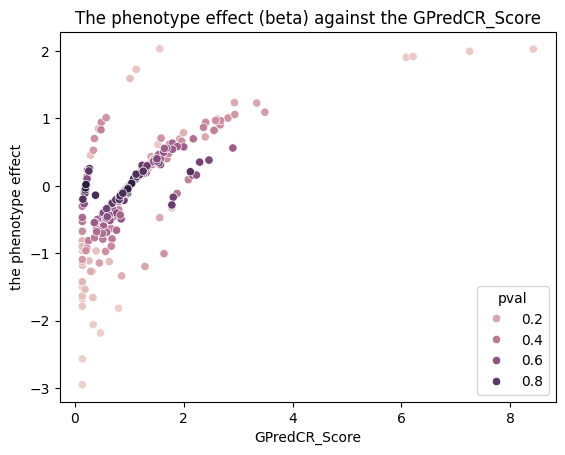

In [66]:
# plot the data points and color the points by pval
sns.scatterplot(data=merged_df, x='GPredCR_Score', y='beta', hue='pval')
plt.xlabel('GPredCR_Score')
plt.ylabel('the phenotype effect')
plt.title('The phenotype effect (beta) against the GPredCR_Score')

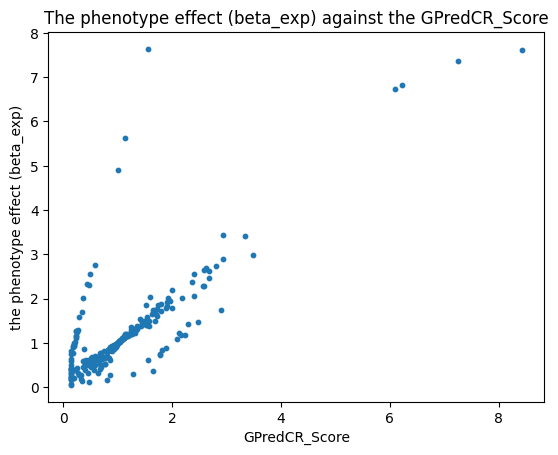

In [68]:
merged_df['beta_exp'] = np.exp(merged_df['beta'])

# Plot the results
plt.scatter(merged_df['GPredCR_Score'], merged_df['beta_exp'], s=10)
plt.xlabel('GPredCR_Score')
plt.ylabel('the phenotype effect (beta_exp)')
plt.title('The phenotype effect (beta_exp) against the GPredCR_Score')
plt.show()

/var/folders/7w/rj_0j9_94558rkgpj7x7fydh0000gn/T/ipykernel_50172/1597545465.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


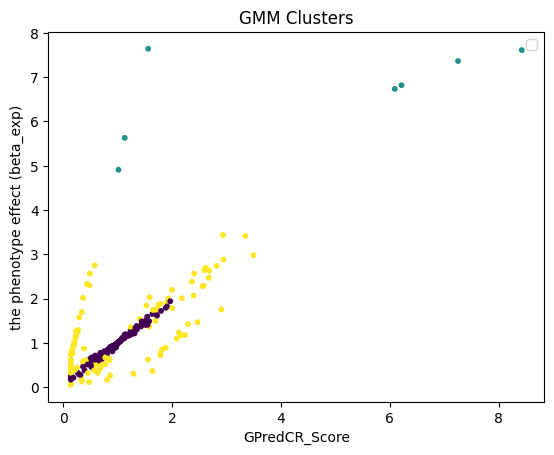

In [69]:
# Cluster the points using GMM
# Standardize the data
scaler = StandardScaler()
X = merged_df[['GPredCR_Score', 'beta_exp']].values
X_scaled = scaler.fit_transform(X)
gmm = GaussianMixture(n_components=3, random_state=0)
labels_gmm = gmm.fit_predict(X_scaled)

# Add the cluster labels to the dataframe
merged_df['Cluster_GMM'] = labels_gmm

# Plot the original data with GMM clusters
plt.scatter(merged_df['GPredCR_Score'], merged_df['beta_exp'], c=merged_df['Cluster_GMM'], cmap='viridis', s=10)
plt.xlabel('GPredCR_Score')
plt.ylabel('the phenotype effect (beta_exp)')
plt.title('GMM Clusters')
plt.show()

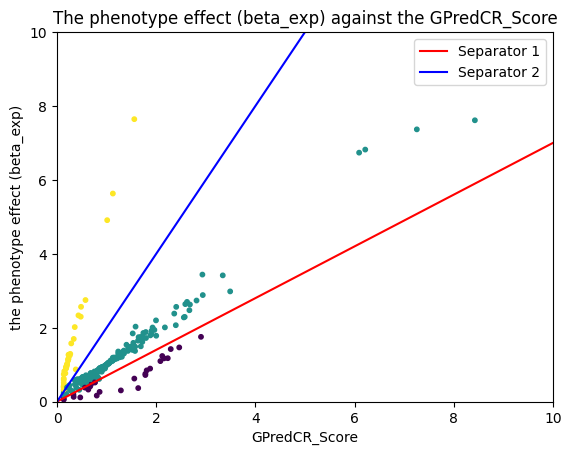

In [38]:
# Define the separators manually (you can adjust these values based on the plot)
separator_1 = {'slope': 0.7, 'intercept': 0}
separator_2 = {'slope': 2, 'intercept': 0}

# Function to calculate y values based on slope and intercept
def calculate_y(x, slope, intercept):
    return slope * x + intercept

# Generate x values for the separators
x_vals = np.linspace(0, 10, 100)

# Calculate y values for the separators
y_vals_1 = calculate_y(x_vals, separator_1['slope'], separator_1['intercept'])
y_vals_2 = calculate_y(x_vals, separator_2['slope'], separator_2['intercept'])

# Function to classify points based on separators
def classify_points(x, y, sep1, sep2):
    y1 = calculate_y(x, sep1['slope'], sep1['intercept'])
    y2 = calculate_y(x, sep2['slope'], sep2['intercept'])
    
    if y < y1:
        return 0
    elif y < y2:
        return 1
    else:
        return 2

# Apply classification
merged_df['Cluster'] = merged_df.apply(lambda row: classify_points(row['GPredCR_Score'], row['beta_exp'], separator_1, separator_2), axis=1)

# Plot the classified points with separators
plt.scatter(merged_df['GPredCR_Score'], merged_df['beta_exp'], c=merged_df['Cluster'], cmap='viridis', s=10)
plt.plot(x_vals, y_vals_1, color='red', label='Separator 1')
plt.plot(x_vals, y_vals_2, color='blue', label='Separator 2')
plt.xlabel('GPredCR_Score')
plt.ylabel('the phenotype effect (beta_exp)')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title('The phenotype effect (beta_exp) against the GPredCR_Score')
plt.legend()
plt.show()


Text(0.5, 1.0, 'The phenotype effect (beta) against the GPredCR_Score')

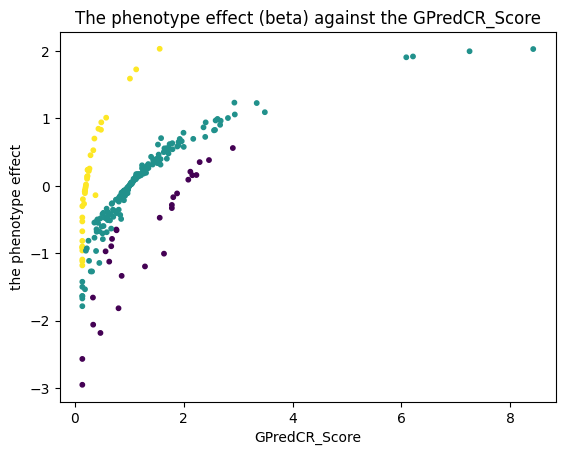

In [39]:
# Plot the phenotype effect (beta) against the score with legend
# color the points by cluster
plt.scatter(merged_df['GPredCR_Score'], merged_df['beta'], c=merged_df['Cluster'], cmap='viridis', s=10)
plt.xlabel('GPredCR_Score')
plt.ylabel('the phenotype effect')
plt.title('The phenotype effect (beta) against the GPredCR_Score')

Cluster 1: Intercept = 0.025757321010602352, Coefficient = 0.9861395073168777
Score of model 1: 0.9829652826184363
Cluster 2: Intercept = -0.09214544828900229, Coefficient = 5.0255346070471125
Score of model 2: 0.9799023539401491
Cluster 0: Intercept = -0.07572725902508615, Coefficient = 0.5536150674058897
Score of model 0: 0.8700839750219822


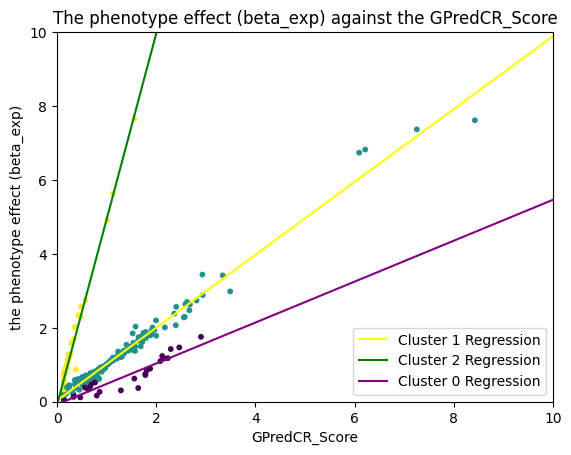

In [40]:
# Initialize models for each cluster
models = {}

# Train a model for each cluster
for cluster in merged_df['Cluster'].unique():
    cluster_data = merged_df[merged_df['Cluster'] == cluster]
    X = cluster_data[['GPredCR_Score']].values
    y = cluster_data['beta_exp'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    models[cluster] = model
    print(f"Cluster {cluster}: Intercept = {model.intercept_}, Coefficient = {model.coef_[0]}")
    print(f"Score of model {cluster}: {model.score(X, y)}")

# Plot the original data with clusters
plt.scatter(merged_df['GPredCR_Score'], merged_df['beta_exp'], c=merged_df['Cluster'], cmap='viridis', s=10)


# Plot the regression lines for each cluster
colors = ['yellow', 'green', 'purple']
for cluster, color in zip(models.keys(), colors):
    model = models[cluster]
    y_vals = model.predict(x_vals.reshape(-1, 1))
    plt.plot(x_vals, y_vals, color=color, label=f'Cluster {cluster} Regression')

plt.xlabel('GPredCR_Score')
plt.ylabel('the phenotype effect (beta_exp)')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title('The phenotype effect (beta_exp) against the GPredCR_Score')
plt.legend()
plt.show()


In [41]:
class Model:
    def __init__(self, vid_map, model):
        self.vid_map = vid_map
        self.model = model
    def predict(self, X, vids):
        # find the cluster of each point based on variant_id
        clusters = []
        for vid in vids:
            this_cluster = None
            for cluster, vids in self.vid_map.items():
                if vid in vids:
                    this_cluster = cluster
                    break
            clusters.append(this_cluster)
        # predict the phenotype effect based on the cluster
        predictions = []
        for cluster, x in zip(clusters, X):
            if cluster is None:
                predictions.append(None)
                continue
            model = self.model[cluster]
            prediction = model.predict([[x]])
            predictions.append(prediction)
        return np.array(predictions)

In [42]:
cluster_0_vids = list(merged_df[merged_df['Cluster'] == 0]['variant_id'])
cluster_1_vids = list(merged_df[merged_df['Cluster'] == 1]['variant_id'])
cluster_2_vids = list(merged_df[merged_df['Cluster'] == 2]['variant_id'])
vid_map = {0: cluster_0_vids, 1: cluster_1_vids, 2: cluster_2_vids}

model = Model(vid_map, models)
vids = merged_df['variant_id'].values
X = merged_df['GPredCR_Score'].values
y = merged_df['beta_exp'].values
y_pred = model.predict(X, vids)

# calculate mean squared percentage error, ignoring the points with None prediction
def mean_absolute_percentage_error(y_true, y_pred):
    errors = []
    for true, pred in zip(y_true, y_pred):
        if pred[0] is np.nan or true == 0:
            continue
        errors.append(np.abs((true - pred[0]) / true))
    return np.nanmean(errors)

# print the mean absolute percentage error to the 4th decimal place
print(f"Training Mean Absolute Percentage Error: {mean_absolute_percentage_error(y, y_pred)*100:.4f}%")

Training Mean Absolute Percentage Error: 12.5252%


<Axes: xlabel='GPredCR_Score', ylabel='beta'>

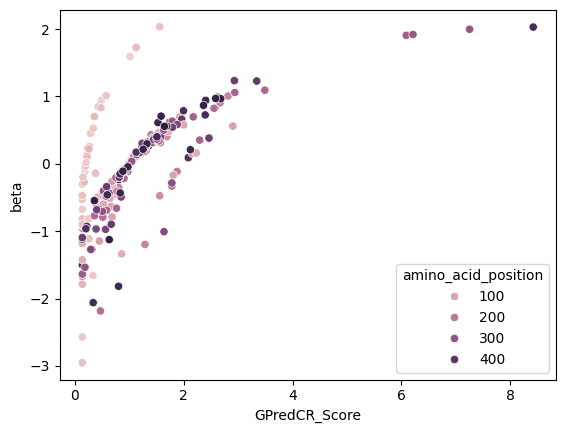

In [64]:
# plot the data points and color the points by pval
sns.scatterplot(data=merged_df, x='GPredCR_Score', y='beta', hue='amino_acid_position')

<Axes: xlabel='GPredCR_Score', ylabel='beta'>

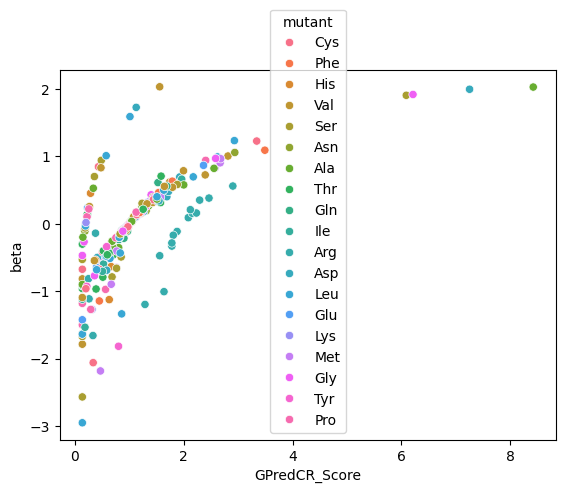

In [65]:
# plot the data points and color the points by pval
sns.scatterplot(data=merged_df, x='GPredCR_Score', y='beta', hue='mutant')

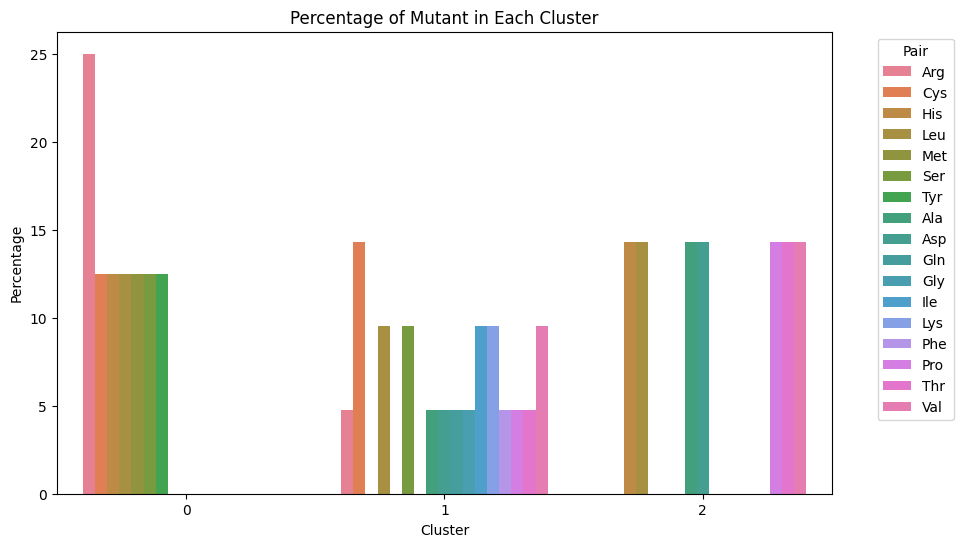

In [28]:
# Calculate the counts of each mutant for each cluster
counts = merged_df.groupby(['Cluster', 'mutant']).size().reset_index(name='count')

# Calculate the total count for each cluster
total_counts = counts.groupby('Cluster')['count'].transform('sum')

# Calculate the percentage
counts['percentage'] = (counts['count'] / total_counts) * 100

# Plot the percentage of each mutant in each cluster
plt.figure(figsize=(10, 6))
sns.barplot(data=counts, x='Cluster', y='percentage', hue='mutant')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title('Percentage of Mutant in Each Cluster')
plt.legend(title='Pair', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [70]:
merged_df[merged_df['GPredCR_Score']>4]

,Unnamed: 0,variant_id,consequence,wildtype,amino_acid_position,mutant,beta,pval,allele_count,allele_frequency,homozygote_count,GPredCR_Score,beta_exp,Cluster_GMM,Cluster
209,241,6-154090064-G-T,missense_variant,Ala,270,Ser,1.907325,0.040135,1,0.000001,0,6.0903,6.735046,1,1
212,244,6-154090107-T-G,missense_variant,Val,284,Gly,1.919584,0.038877,1,0.000001,0,6.2138,6.818123,1,1
214,246,6-154090137-G-A,missense_variant,Gly,294,Asp,1.996760,0.031665,1,0.000001,0,7.2538,7.365154,1,1
250,285,6-154091336-A-C,missense_variant,Glu,436,Ala,2.029583,0.028970,1,0.000001,0,8.4241,7.610914,1,1
